In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../static/data/processData/application_train.csv')

In [3]:
df[df.select_dtypes('number').columns].corr()['TARGET'].sort_values(ascending=False)[:20]

TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
OWN_CAR_AGE                    0.037612
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
FLAG_WORK_PHONE                0.028524
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
CNT_CHILDREN                   0.019187
CNT_FAM_MEMBERS                0.009308
OBS_30_CNT_SOCIAL_CIRCLE       0.009131
Name: TARGET, dtype: float64

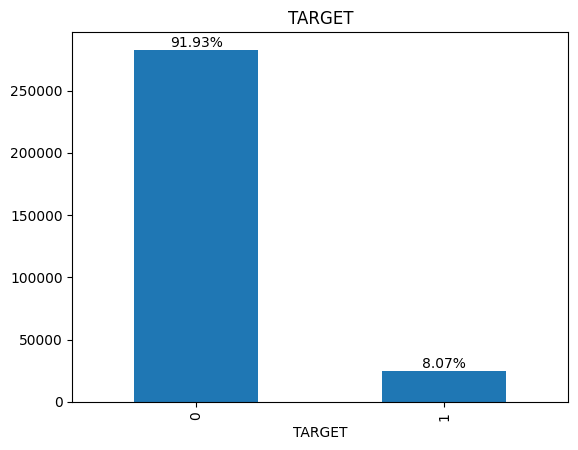

In [4]:
# Calculate the value counts
value_counts = df['TARGET'].value_counts()

# Create the bar chart
ax = value_counts.plot(kind='bar')
plt.title('TARGET')

# Add percentage labels on top of the bars
total = len(df['TARGET'])
for i, v in enumerate(value_counts):
    percentage = (v / total) * 100
    ax.text(i, v, f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()

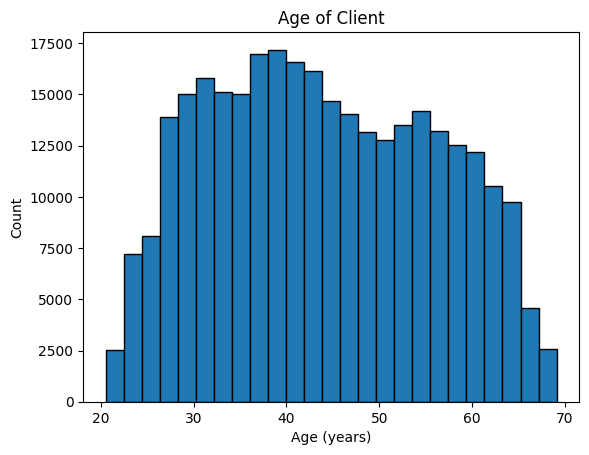

In [5]:
# Plot the distribution of ages in years
plt.hist(df['DAYS_BIRTH'] / -365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.

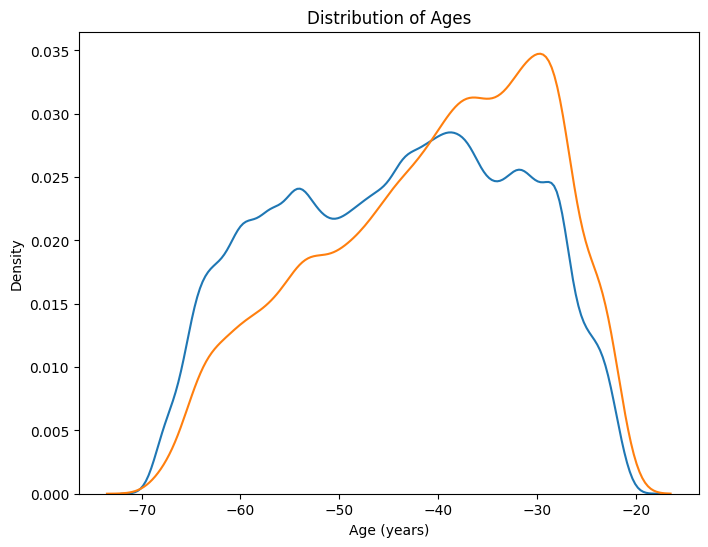

In [6]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [7]:
# Age information into a separate dataframe
age_data = df[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.sample(5)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
264240,0,-8201,22.468493,"(20.0, 25.0]"
251853,0,-20882,57.210959,"(55.0, 60.0]"
231572,0,-18874,51.709589,"(50.0, 55.0]"
58293,0,-11905,32.616438,"(30.0, 35.0]"
73893,1,-8763,24.008219,"(20.0, 25.0]"


In [8]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,-8532.795625,23.377522
"(25.0, 30.0]",0.111436,-10155.219250,27.822518
"(30.0, 35.0]",0.102814,-11854.848377,32.479037
"(35.0, 40.0]",0.089414,-13707.908253,37.555913
"(40.0, 45.0]",0.078491,-15497.661233,42.459346
"(45.0, 50.0]",0.074171,-17323.900441,47.462741
"(50.0, 55.0]",0.066968,-19196.494791,52.593136
"(55.0, 60.0]",0.055314,-20984.262742,57.491131
"(60.0, 65.0]",0.052737,-22780.547460,62.412459


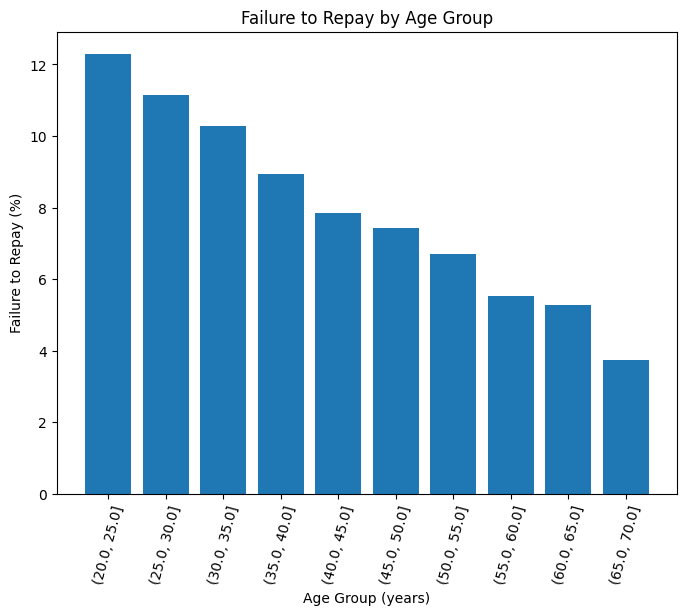

In [9]:
plt.figure(figsize = (8, 6))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

* There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

* This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

* REGION_RATING_CLIENT_W_CITY: Our rating of the region where client lives with taking city into account (1,2,3)

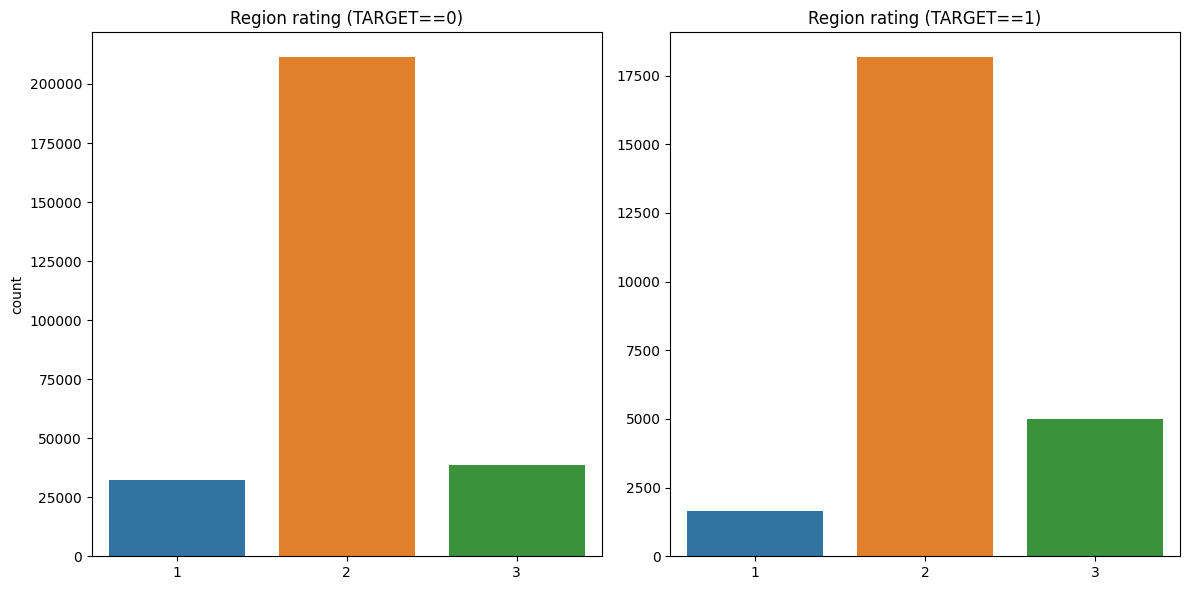

In [10]:
# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(12, 6))

# Plot the countplot for TARGET==0
plt.subplot(1, 2, 1)
sns.countplot(x=df[df.TARGET == 0].REGION_RATING_CLIENT_W_CITY, data=df[df.TARGET == 0])
plt.xlabel('')
plt.title('Region rating (TARGET==0)')

# Plot the countplot for TARGET==1
plt.subplot(1, 2, 2)
sns.countplot(x=df[df.TARGET == 1].REGION_RATING_CLIENT_W_CITY, data=df[df.TARGET == 1])
plt.xlabel('')
plt.ylabel('')
plt.title('Region rating (TARGET==1)')

plt.tight_layout()# Adjust spacing between subplots
plt.show()

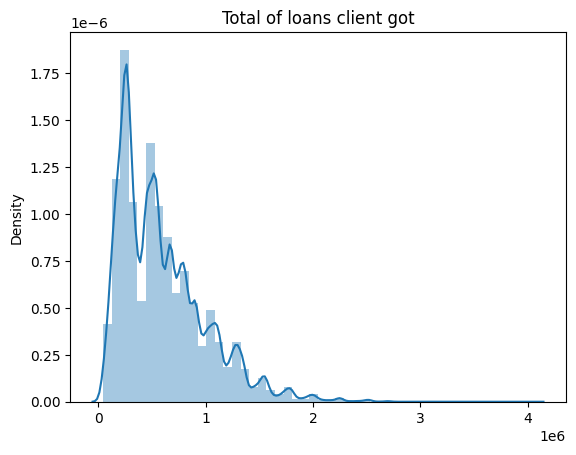

In [11]:
sns.distplot(df['AMT_CREDIT'])
plt.xlabel(' ')
plt.title('Total of loans client got');

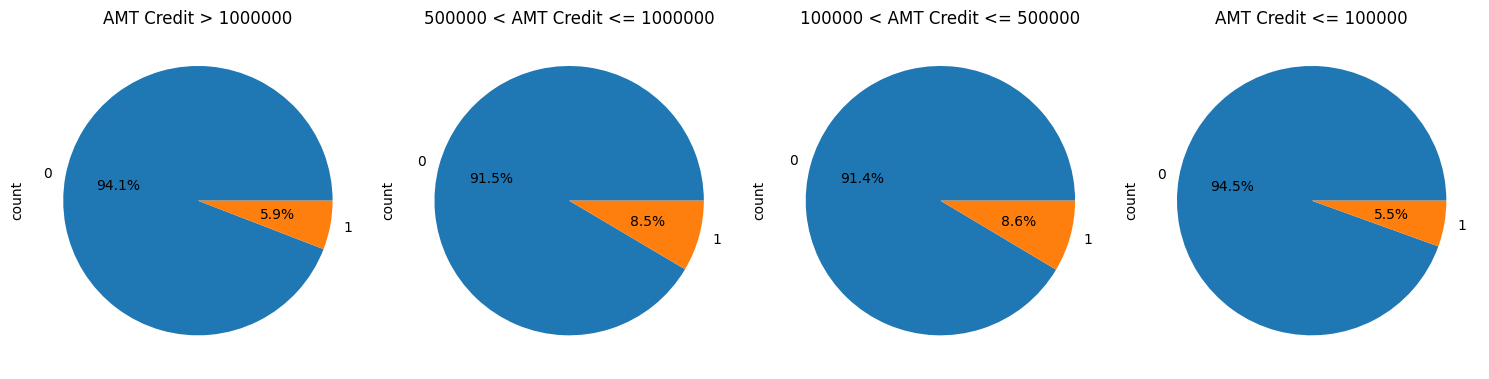

In [12]:
# Filter data and calculate value counts for each category
count_large = df[df['AMT_CREDIT'] > 1000000]['TARGET'].value_counts()
count_medium2 = df[(df['AMT_CREDIT'] <= 1000000) & (df['AMT_CREDIT'] > 50000)]['TARGET'].value_counts()
count_medium1 = df[(df['AMT_CREDIT'] <= 500000) & (df['AMT_CREDIT'] > 100000)]['TARGET'].value_counts()
count_small = df[df['AMT_CREDIT'] <= 100000]['TARGET'].value_counts()

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the pie charts in each subplot
count_large.plot(kind='pie', autopct='%1.1f%%', ax=axes[0])
count_medium2.plot(kind='pie', autopct='%1.1f%%', ax=axes[1])
count_medium1.plot(kind='pie', autopct='%1.1f%%', ax=axes[2])
count_small.plot(kind='pie', autopct='%1.1f%%', ax=axes[3])

# Set titles for each subplot
axes[0].set_title('AMT Credit > 1000000')
axes[1].set_title('500000 < AMT Credit <= 1000000')
axes[2].set_title('100000 < AMT Credit <= 500000')
axes[3].set_title('AMT Credit <= 100000')

# Adjust layout
plt.tight_layout()

plt.show();

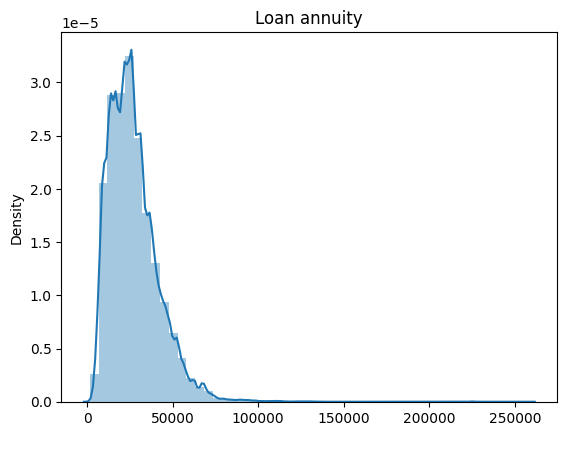

In [13]:
sns.distplot(df['AMT_ANNUITY'])
plt.xlabel(' ')
plt.title('Loan annuity');

**Object features**

In [14]:
df[df.select_dtypes('object').columns].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


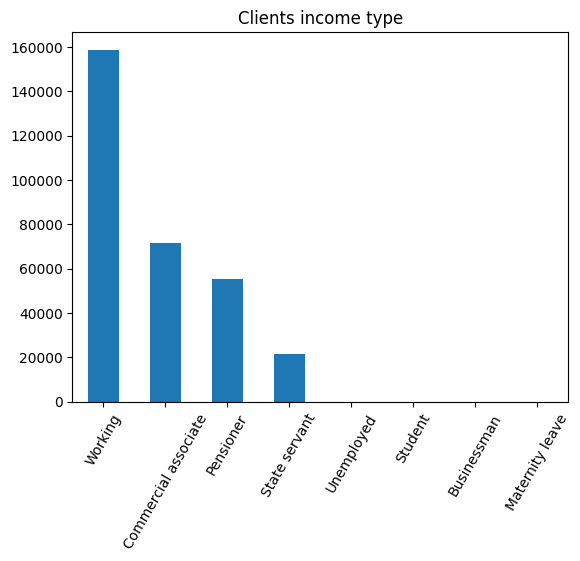

In [15]:
df.NAME_INCOME_TYPE.value_counts().plot(kind='bar');
plt.xticks(rotation=60)
plt.title('Clients income type')
plt.xlabel('')
plt.show();

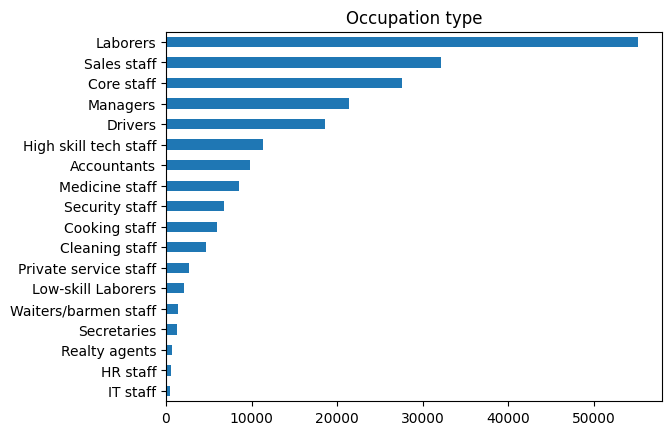

In [16]:
df.OCCUPATION_TYPE.value_counts().sort_values().plot(kind='barh')
plt.ylabel('')
plt.title('Occupation type')
plt.show();

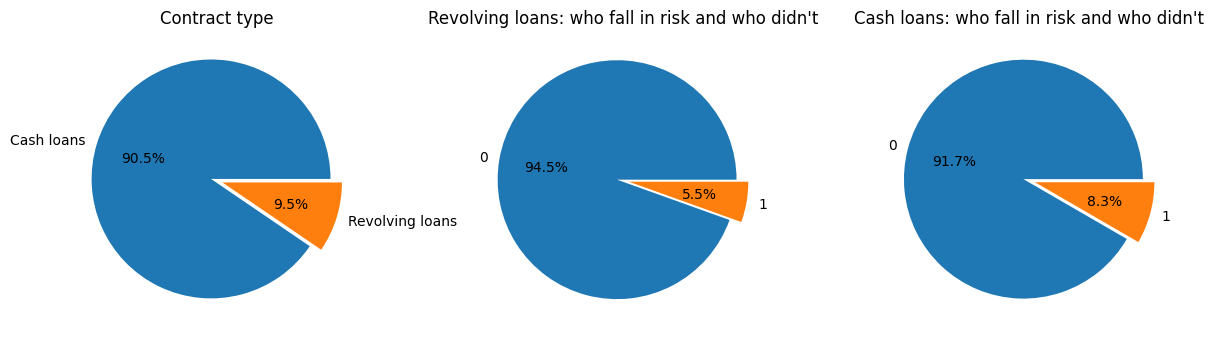

In [17]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 5))


df.NAME_CONTRACT_TYPE.value_counts().plot(
    kind='pie',
    explode = [0.05,0.05],
    title = 'Contract type',
    autopct = '%1.1f%%',
    ax=axs[0]
)
axs[0].set_ylabel('')

# Plot the first pie chart for Revolving loans
df[df.NAME_CONTRACT_TYPE == 'Revolving loans']['TARGET'].value_counts().plot(
    kind='pie',
    explode=[0.05, 0.05],
    title='Revolving loans: who fall in risk and who didn\'t',
    autopct='%1.1f%%',
    ax=axs[1]  # Use the first subplot
)
axs[1].set_ylabel('')  # Remove the y-label

# Plot the second pie chart for Cash loans
df[df.NAME_CONTRACT_TYPE == 'Cash loans']['TARGET'].value_counts().plot(
    kind='pie',
    explode=[0.05, 0.05],
    title='Cash loans: who fall in risk and who didn\'t',
    autopct='%1.1f%%',
    ax=axs[2]  # Use the second subplot
)
axs[2].set_ylabel('')  # Remove the y-label

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

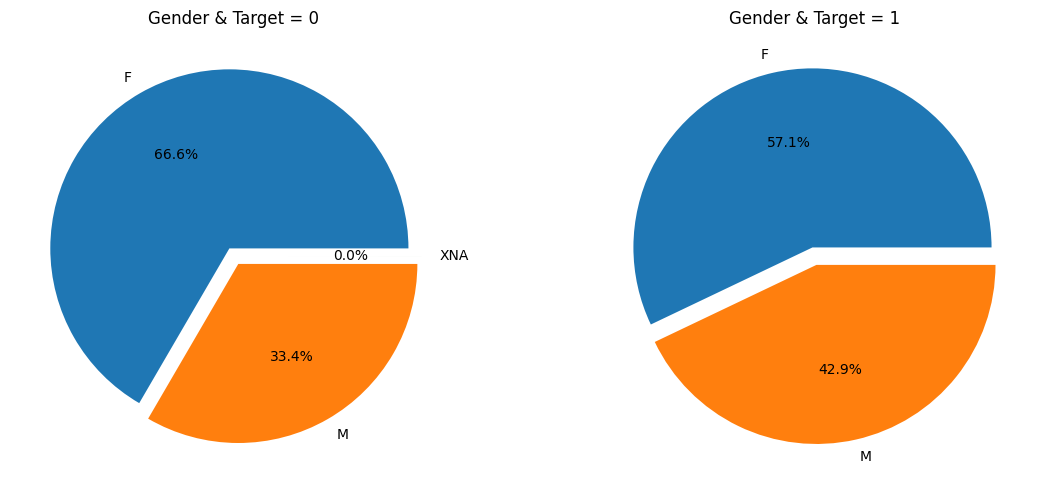

In [18]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

df[df.TARGET == 0].CODE_GENDER.value_counts().plot(
    kind='pie',
    explode = [0.05, 0.05, 0.05],
    title = 'Gender & Target = 0',
    autopct = '%1.1f%%',
    ax=axs[0]
)
axs[0].set_ylabel('')

df[df.TARGET == 1].CODE_GENDER.value_counts().plot(
    kind='pie',
    explode = [0.05, 0.05],
    title = 'Gender & Target = 1',
    autopct = '%1.1f%%',
    ax=axs[1]
)
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()


* Drop XNA from gender in processing

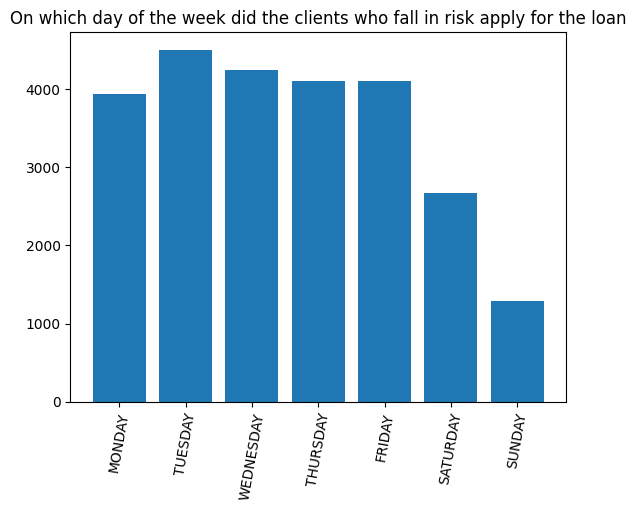

In [19]:
days = np.array(['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY'])
cnt = np.array([
    sum(df[df.TARGET==1].WEEKDAY_APPR_PROCESS_START == 'MONDAY'),
    sum(df[df.TARGET==1].WEEKDAY_APPR_PROCESS_START == 'TUESDAY'),
    sum(df[df.TARGET==1].WEEKDAY_APPR_PROCESS_START == 'WEDNESDAY'),
    sum(df[df.TARGET==1].WEEKDAY_APPR_PROCESS_START == 'THURSDAY'),
    sum(df[df.TARGET==1].WEEKDAY_APPR_PROCESS_START == 'FRIDAY'),
    sum(df[df.TARGET==1].WEEKDAY_APPR_PROCESS_START == 'SATURDAY'),
    sum(df[df.TARGET==1].WEEKDAY_APPR_PROCESS_START == 'SUNDAY')
])

plt.title('On which day of the week did the clients who fall in risk apply for the loan')
plt.bar(days, cnt)
plt.xticks(rotation=80)
plt.show();

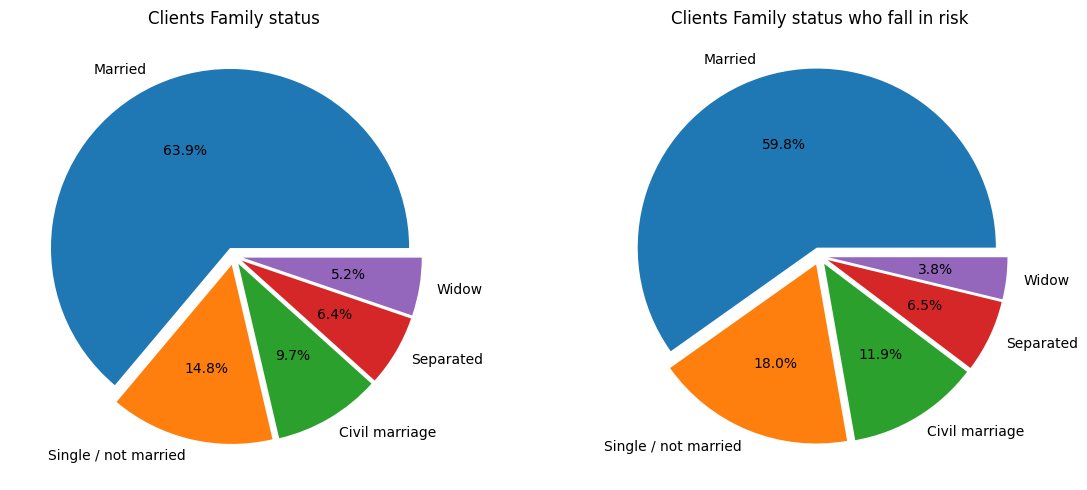

In [20]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

df.NAME_FAMILY_STATUS.value_counts()[:5].plot(
    kind='pie',
    explode = [0.05,0.05,0.05,0.05,0.05],
    title = 'Clients Family status',
    autopct = '%1.1f%%',
    ax = axs[0]
)
axs[0].set_ylabel('')

df[df.TARGET==1].NAME_FAMILY_STATUS.value_counts()[:5].plot(
    kind='pie',
    explode = [0.05,0.05,0.05,0.05,0.05],
    title = 'Clients Family status who fall in risk',
    autopct = '%1.1f%%',
    ax = axs[1]
)
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [21]:
df[df.NAME_FAMILY_STATUS == 'Unknown']['TARGET'] # delete them in the data processing

41982     0
187348    0
Name: TARGET, dtype: int64

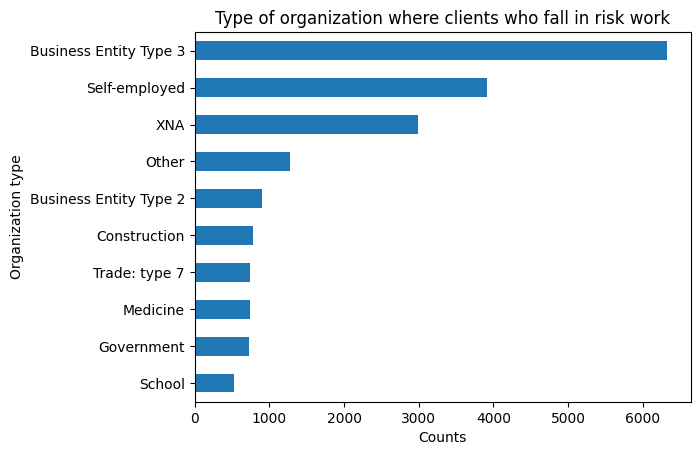

In [22]:
df[df.TARGET==1].ORGANIZATION_TYPE.value_counts()[:10].sort_values().plot(kind='barh');

plt.xlabel('Counts')
plt.title('Type of organization where clients who fall in risk work')
plt.ylabel("Organization type")
plt.show();

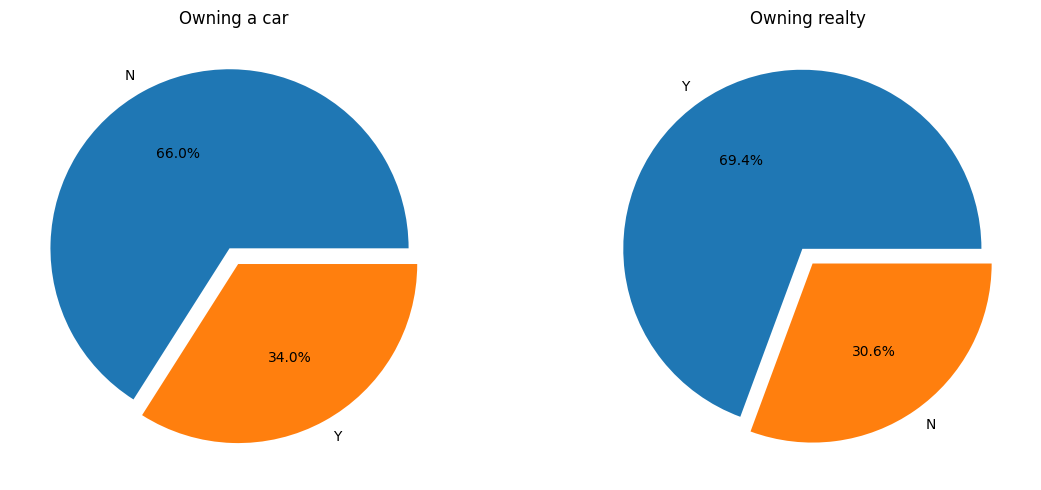

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

df.FLAG_OWN_CAR.value_counts().plot(
    kind='pie',
    explode=[0.05, 0.05],
    title='Owning a car',
    autopct='%1.1f%%',
    ax=axs[0]
)
axs[0].set_ylabel('')

df.FLAG_OWN_REALTY.value_counts().plot(
    kind='pie',
    explode=[0.05, 0.05],
    title='Owning realty',
    autopct='%1.1f%%',
    ax=axs[1]
)
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()